### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

# This command makes plots appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# A/B-тестирование и бутстрэп анализ при оценки коэффициента удержания

## 1. Описание сути A/B-тестирования
Cookie Cats</a> является популярной игрой от разработчика <a href="http://tactile.dk">Tactile Entertainment</a>. Данная игра представляет собой классический трехуровневый пазл, в котором игрок должен соединить элементы одинакового цвета для того чтобы очистить экран и выиграть.
<p> В течение игры при переходе на очередной уровень, пользователи периодически видят заглушку и вынуждены ожидать некоторое время для перехода на следующий уровень, либо внести определенную сумму и продолжить игру без ожидания. Помимо монетизации, заглушки между уровнями вынуждают игрока сделать перерыв, что в конечном счете позволяет сохранить интерес пользователя к игре.</p>

<p>A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель. В данном кейсе особое внимание будет уделено такому важному показателю как показатель Удержания клиента (player retention rate).
    
<p>Ключевым вопросом при данном подходе, является вопрос на каком уровне установить заглушки? Изначально заглушка была установлена на 30 уровне игры. В данном кейсе произведен A/B-тестирование  пользовательской активности в случае, когда заглушка будет перенесена на 40 уровень игры. </p>

__Главная задача А/В-тестирования__ : ответить на вопрос влияет ли перенос заглушки в игре на 40 уровень  на удержание клиента (player retention rate)

In [2]:
# чтение файла с данными
df = pd.read_csv('data/cookie_cats.csv')

# показать первые несколько строк данных
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. Данные для A/B-тестирования
<p>Данные содержат информацию о 90,189 игроках, которые установили приложение в момент проведения AB-test. Переменные содержат следующую информацию:</p>
<ul>
<li><code>userid</code> - уникальный номер, который является идентификатором игрока.</li>
<li><code>version</code> - идентификатор включен или нет данный игрок в контрольную группу (<code>gate_30</code> - заглушка на 30 уровне) или в группу игроков, для которых заглушка была перенесена на 40 уровень (<code>gate_40</code> - заглушка на 30 уровне).</li>
<li><code>sum_gamerounds</code> - количество раундов, которые были сыграны игроком в течение первых 14 дней после установки приложения </li>
<li><code>retention_1</code> - вернулся ли игрок обратно  <strong>в течение 1 дня</strong> после установки приложения?</li>
<li><code>retention_7</code> - вернулся ли игрок обратно и играл <strong>в течение 7 дней</strong> после установки приложения?</li>
</ul>
<p>В момент установки игры, каждый игрок случайным образом был распределен либо в контрольную группу <code>gate_30</code> либо <code>gate_40</code>. В первую очередь необходимо убедиться является ли количество игроков примерно одинаковым в контрольной группе и группе, где были произведены изменения.</p>


In [3]:
# Counting the number of players in each AB group.
df.groupby(by = 'version').count()['userid']

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## 3. Кол-во раундов сыгранных пользователям в течение первых 14 дней после установки игры

### Распределение уровней пройденных пользователями 
<p>Сначала проанализируем распределение количества раундов, которые пользователи сыграли в течение первой недели после установки приложения.</p>

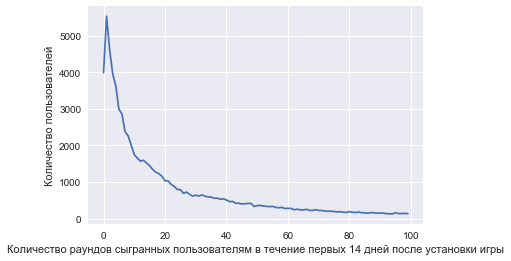

In [4]:
# сколько игроков достигли определенного раунда 
plot_df = df.groupby(by = 'sum_gamerounds')['userid'].count()

# распределение игроков которые сыграли от 0 до 100 раундов в течение первых 14 дней после установки
ax = plot_df.head(100).plot( x = 'sum_gamerounds', y = 'userid')
_= ax.set_xlabel("Количество раундов сыгранных пользователям в течение первых 14 дней после установки игры")
_= ax.set_ylabel("Количество пользователей")

__В соответствии с графиком распределения:__ более 5000 игроков либо не вернулись к приложению после установки, либо сыграли меньше 5 раундов в течение первых 14 дней после установки

### Функция распределения уровней пройденных пользователями

In [5]:
def ecdf(data):
    """Cumulative distribution function """
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

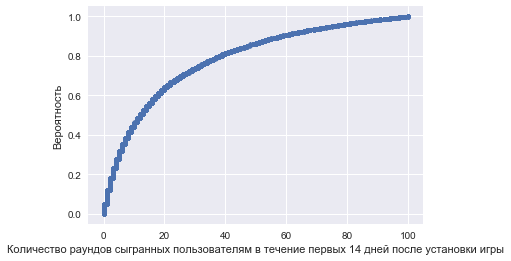

In [6]:
x, y = ecdf(df[df.sum_gamerounds<=100].sum_gamerounds.values)

_=plt.plot(x, y, marker = '.', linestyle = 'none')
_=plt.xlabel('Количество раундов сыгранных пользователям в течение первых 14 дней после установки игры')
_=plt.ylabel('Вероятность')

plt.show()

__В соответствии c функцией распределения:__ с вероятностью 80% игрок сыграет меньше 40 раундов в первые 14 дней после установки

## 4. Общий коэффициент удержания (retention rate) в течение 1 дня после установки
<p> В соответствии с графиками распределения, подавляющее количество игроков после установки игры либо никогда не открывают  приложение (0 раундов), либо играют всего лишь несколько раз. Лишь относительно небольшое количество пользователей играют 100 либо больше раундов. </p>
<p>Основная цель разработчика игры как можно дольше удерживать внимание пользователя. Одна из самых распространенных метрик для оценки данного показателя является <em>коэффициент удержания в течение первого дня после установки приложения</em>: количество игроков в процентном выражении, которые возвращаются к приложению <em>в течение первого дня</em> после того как они установили приложение. Чем выше данный показатель, тем проще удерживать пользователей и наращивать клиентскую базу.</p>
<p>Общий коэффициент удержания (retention rate) в течение 1 дня после установки.</p>

In [7]:
# Кол-во пользователей в процентном выражении, которые вернулись к приложению и продолжили им пользоваться в течение первого дня после установки
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

## 5. Коэффициент удержания (retention rate) в течение 1 дня после установки в зависимости от того к какой группе относиться пользователь
<p>Общий коэффициент удержания в течение первого дня чуть меньше чем 50%. Данный показатель может служить как benchmark. Далее проанализируем каким образом коэффициент удержания (retention rate) в течение 1 дня после установки зависит от того к какой группе к контрольной или тестовой относиться пользователь</p>

In [8]:
# коэффициент удержания (retention rate) в течение 1 дня после установки для тестовой и контрольной групп
df.groupby('version')['retention_1'].sum() / df.groupby('version')['retention_1'].count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. Насколько мы можем быть уверены в результате при оценке коэффициента удержания ?
Согласно расчетам коэффициент удержания в течение первого дня незначительно снизился, когда мы внесли изменения в приложение и перенесли заглушку на 40 уровень (44.2%) по сравнению с контрольной группой где заглушка осталась на 30 уровне игры (44.8%). На первый взгляд разница невелика, но даже небольшое изменение коэффициента удержания может иметь огромное влияние на все остальные показатели. Несмотря на то, что мы уверены в небольшой разнице в показателе между контрольной и тестовой группами, насколько мы можем быть уверены, что перенос заглушки на 40 уровень также снизит коэффициент удержание в будущем?

<pr>Существует несколько статистических приемов при помощи которых мы можем оценить наш результат и быть в нем уверены.В данном случае мы будем использовать бутстрэп, главная идея которого заключается в использовании повторной выборки с заменой из текущих данных и повторное вычисление интересующей нас метрики для новой выборки. Отклонение коэффициента удержания в течение 1 дня поможет оценить насколько изменчив интересующий нас показатель в данном случае коэффициент удержания.

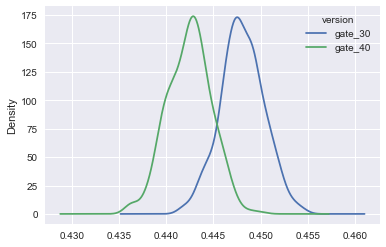

In [9]:
# сделать 500 выборок с заменой из текущих данных и расчитать коэффициент удержания для тестовой и контрольной групп.
boot_1d = []
for i in range(500):
    boot_mean = df.sample(replace = True, frac = 1).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
# графики оценки плотности распределения для АВ групп
_= boot_1d.plot(kind = 'density')

## 7. Разница в коэффициенте удержания между тестовой и контрольной группами
<p>Два верхних графика показывают отклонение коэффициента удержания в течение первого дня для контрольной и тестовой групп </p>
<p>Для того, чтобы лучше оценить результат А/В-тестирования и как это повлияло на коэффициент удержания, рассчитаем разницу между показателями полученными в результате повторных выборок для контрольной и тестовой групп и построим график </p>
<p>(<em>Важный момент: в данном случае было сгенерировано 500 выборок для того чтобы произвести вычисления быстрее, на практике обычно используется около 10 000 выборок.</em>)</p>

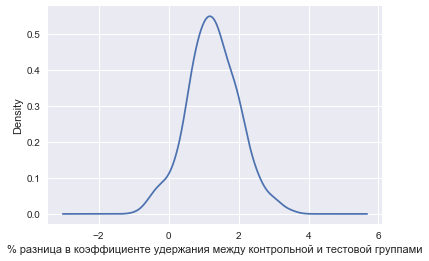

In [10]:
#разница выраженная в процентах между показателями полученными в результате повторных выборок для контрольной и тестовой групп
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# график оценки разницы коэффициента удержания в контрольной и тестовой группах
ax = boot_1d['diff'].plot(kind = 'density')
_= ax.set_xlabel("% разница в коэффициенте удержания между контрольной и тестовой группами")

## 8. Вероятность разницы коэффициента удержания
<p>Из графика, представленного выше, можно сделать вывод, что с наибольшей вероятностью разница в коэффициенте удержания в течение первого дня будет примерно 1% - 2%. Большинство значений функции распределения больше 0%, это говорит о том, что значение коэффициента удержания для контрольной группы больше чем для тестовой группы.  Какова <em>вероятность</em> что разница между коэффициентами удержания больше нуля?</p>

In [11]:
# вероятность что коэффициент удержания в течение 1 дня после установки больше для контрольной группы (заглушка на 30 уровне игры)
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

print('{:.1%}'.format(prob))

94.8%


## 9. Коэффициент удержания в течение первых 7 дней после утановки для контрольной и тестовой групп
<p>На основе проведенного бутстрэп анализа можно сделать вывод, что с высокой долей вероятности, коэффициент удержания в течение первого дня после установки выше для контрольной группы, где не было произведено никаких изменений (блокировка на 30 уровне игры). Однако маловероятно что пользователь достигнет 30 либо 40 уровня в течение первого после установки.  данное различие может быть объяснено что несколько наиболее активных пользователей смогли достичь 30 уровня в течение первого для после установки игры. </p>
<p>Намного интересней проанализировать коэффициент удержания в течение первых семи дней после установки, когда игрок с высокой долей вероятности достигнет 40 игры. Каков процент пользователей, которые вновь откроют приложение и продолжат играть по истечение первой недели после установки?</p>
<p>Расчет коэффициента удержания в течение первых 7 дней после установки для контрольной и тестовой групп.</p>

In [12]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Бутстрэп анализ для коэффициента удержания в течение первых 7 дней после установки приложения
<p>Так же, как и в случае с коэффициентом удержания в течение первого дня видно, что коэффициент удержания в течение первых 7 дней после установки приложения немного меньше (18.2%) когда блокировка установлена на 40 уровне игры чем у контрольной группы пользователей для которых блокировка была оставлена без изменений на 30 уровне игры (19.0%). Так же из данных следует, что в целом коэффициент удержания в течение 7 дней после установки значительно меньше чем коэффициент удержания пользователей в течение 1 дня после установки приложения.</p>
<p>Так же как и для коэффициента удержания в течение первого дня проведем бутстрэп анализ для коэффициента удержания в течение первых семи дней, на основе которого мы сможем быть уверены в разницы данного показателя между двумя группами пользователей.</p>

94.8%


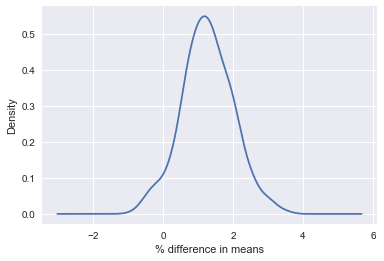

In [13]:
# сделать 500 выборок с заменой из текущих данных и расчитать коэффициент удержания для тестовой и контрольной групп.
boot_7d = []
for i in range(500):
    boot_mean = df.sample(replace = True, frac = 1).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    

boot_7d = pd.DataFrame(boot_1d)

#разница выраженная в процентах между показателями полученными в результате повторных выборок для контрольной и тестовой групп
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# график оценки разницы коэффициента удержания в контрольной и тестовой группах
ax = boot_7d['diff'].plot(kind = 'density')
ax.set_xlabel("% difference in means")

# вероятность что коэффициент удержания в течение 7 дней после установки больше для контрольной группы (заглушка на 30 уровне игры)
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print('{:.1%}'.format(prob))

## 11.  Заключение
<p> Результат полученный в результате бутстрэп анализа подтверждает, что коэффициент удержания пользователей в течение первых 7 дней после установки выше для контрольной группы с блокировкой на 30 уровне игры, чем у группы с блокировкой установленной на 40 уровне.
    
На основе этих данных мы можем сделать вывод, если мы хотим сохранить высокий коэффициент удержания как в первый день после установки так и по истечение 7 дней, мы должны оставить блокировку на 30 уровне игры без изменений. Помимо удержания существует другие метрики на которые стоит обратить внимание, такие как сколько раундов в игре приходится на игрока или какое количество платных транзакций было произведено как в контрольной так и тестовой группе. Однако коэффициент удержания, является одной из наиболее важных метрик, т.к. если мы не сможем удерживать пользователей и наращивать пользовательскую базу, будет уже не столько важным вопрос о том, сколько в среднем игрок тратить денег при прохождении игры.
    
    
<p>Одним из ключевых вопросов остается вопрос: почему коэффициент удержания выше когда мы располагаем заглушку на 30 уровне игры,а не на 40? Одно из возможных объяснений может быть: механизм <em>Гедонистической адаптации</em>. Краткая суть данного механизма заключается в том, что в независимости от всех остальных факторов с течением времени пользователь начинает терять интерес, если мы предоставим ему свободный неограниченный доступ например к игре. Если же мы используем механизм блокировки игры на неопределенное время по прошествии 30 уровней, то мы таким образом стимулируем пользователя вернуться к игре вновь через какое-то время и при этом сохранить его интерес к игре.Если же мы передвигаем блокировку на более высокий уровень игры к примеру на 40, количество игроков достигнувших этого уровня по определению меньше потому что к этому моменту они могут просто потерять интерес к игре.</p>